In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

## We utilise a smaller version of EMNIST here for lesser training time :)

In [13]:
# Load the EMNIST dataset from TensorFlow Datasets
import tensorflow_datasets as tfds

dataset_name = "emnist/byclass"
(ds_full_train, ds_test), ds_info = tfds.load(
    dataset_name,
    split=["train", "test"],
    as_supervised=True,
    with_info=True,
)

# Train-validation split (90%-10%)
train_size = int(0.9 * ds_info.splits['train'].num_examples)
val_size = ds_info.splits['train'].num_examples - train_size

ds_train = ds_full_train.take(int(train_size*0.2))
ds_val = ds_full_train.skip(int(train_size*0.2))

In [14]:
# Data Preprocessing
def preprocess(image, label):
    image = tf.image.resize(image, (28, 28))  # Resize to 28x28 if needed
    image = tf.image.per_image_standardization(image)  # Normalize pixel values
    return image, label

batch_size = 64

ds_train = ds_train.map(preprocess).batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# TensorFlow Docs

Convolutions -> https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

Max Pooling -> https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D

ReLU -> https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU

Fully Connected Layer -> https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

Flatten has been done for you, do it before you start putting FC layers

In [15]:
# Define the CNN model, THEY WILL MODIFY STUFF HERE ________________________

class SimpleCNN(tf.keras.Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128, activation="relu")
        self.fc2 = layers.Dense(62, activation="softmax")

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return self.fc2(x)

model = SimpleCNN()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# ______________________________________________________________________________________

In [16]:
# Training loop
num_epochs = 5
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=num_epochs,
)

Epoch 1/5
1963/1963 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.7288 - loss: 0.9389 - val_accuracy: 0.8272 - val_loss: 0.5110
Epoch 2/5
1963/1963 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.8320 - loss: 0.4803 - val_accuracy: 0.8251 - val_loss: 0.4980
Epoch 3/5
1963/1963 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - accuracy: 0.8434 - loss: 0.4429 - val_accuracy: 0.8386 - val_loss: 0.4727
Epoch 4/5
1963/1963 ━━━━━━━━━━━━━━━━━━━━ 66s 33ms/step - accuracy: 0.8496 - loss: 0.4148 - val_accuracy: 0.8309 - val_loss: 0.5039
Epoch 5/5
1963/1963 ━━━━━━━━━━━━━━━━━━━━ 66s 33ms/step - accuracy: 0.8503 - loss: 0.4102 - val_accuracy: 0.8357 - val_loss: 0.4790


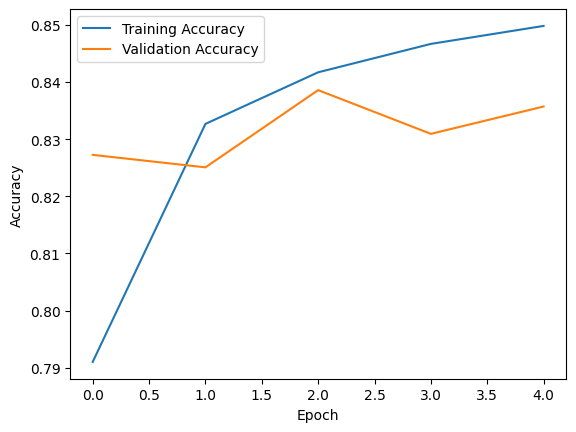

1818/1818 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8381 - loss: 0.4725


Test Accuracy: 83.63%


In [17]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save the model
model.save("emnist_cnn_model.h5")